In [2]:
import pandas as pd
import quandl

In [3]:
QUANDL_KEY = 'et7jqG6esE8zbud7VEaM' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

df = quandl.get(dataset='CHRIS/ICE_NCF1',
                start_date='2008-01-01', 
                end_date='2020-11-04')
df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Settle': 'y'}, inplace=True)

In [4]:
df.tail()

,ds,Open,High,Low,y,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
3046,2020-10-28,NaN,NaN,NaN,58.20,0.05,NaN,NaN,2065.0,NaN,NaN,NaN
3047,2020-10-29,NaN,NaN,NaN,58.20,0.00,NaN,NaN,2065.0,NaN,NaN,NaN
3048,2020-10-30,59.50,59.50,59.50,59.25,0.35,59.50,1.0,2173.0,NaN,NaN,130.0
3049,2020-11-02,59.75,59.75,59.75,59.90,0.65,59.75,5.0,2288.0,NaN,NaN,NaN
3050,2020-11-03,60.00,60.60,60.00,60.55,0.65,60.45,14.0,2253.0,NaN,NaN,NaN


In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [6]:
#Augmented Dickey-Fuller test for stationarity
def adf_test(x):
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results

In [7]:
adf_test(df.y)

Test Statistic              -1.587807
p-value                      0.489716
# of Lags Used               7.000000
# of Observations Used    3043.000000
Critical Value (1%)         -3.432501
Critical Value (5%)         -2.862490
Critical Value (10%)        -2.567276
dtype: float64

In [8]:
# Result indicates that the process is not stationary, 
# p-value shows that the set has 49% non stationary data. we cannot reject the null hypothesis.

In [9]:
#Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
# For this test, we do NOT want to reject the null hypothesis. In other words, we want the p-value to be greater than 0.05 not less than 0.05.

def kpss_test(x, h0_type='ct'):
    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

In [10]:
kpss_test(df.y)

/Users/elizabethmary/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic            0.62965
p-value                   0.01000
# of Lags                29.00000
Critical Value (10%)      0.11900
Critical Value (5%)       0.14600
Critical Value (2.5%)     0.17600
Critical Value (1%)       0.21600
dtype: float64

In [11]:
# The p-value is less than 0.05. The null hypothesis of stationarity is rejected. the data is not   # stationary. regression type ct, h0_type = regression

In [12]:
#the tests show that the nature of the dataset is unpredictable. it's easier to predict stationary data. 

In [13]:
#there is more... 
from pmdarima.arima import ndiffs, nsdiffs

In [14]:
print(f"Suggested # of differences (ADF): {ndiffs(df.y, test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df.y, test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df.y, test='pp')}")

Suggested # of differences (ADF): 1
Suggested # of differences (KPSS): 1
Suggested # of differences (PP): 1


In [15]:
#KPSS test shows that, the data is indeed not stationary (using constant trend regression).

In [16]:
print(f"Suggested # of differences (OSCB): {nsdiffs(df.y, m=12, test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(df.y, m=12, test='ch')}")

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


In [17]:
#The results suggest no seasonality in the dataset.

In [18]:
#Since coal price consists of random walk, it's harder to do forecasting on coal's price.

In [19]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from utils import test_autocorrelation
from fbprophet import Prophet
import seaborn as sns
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing, 
                                         Holt)

In [20]:
df.head()

,ds,Open,High,Low,y,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
0,2008-12-05,72.30,72.30,72.30,72.30,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,2008-12-08,73.60,73.60,73.60,73.60,1.30,NaN,NaN,5.0,NaN,NaN,NaN
2,2008-12-09,74.15,74.15,74.15,74.15,0.55,NaN,NaN,5.0,NaN,NaN,NaN
3,2008-12-10,73.75,73.75,73.75,73.75,-0.40,NaN,NaN,5.0,NaN,NaN,NaN
4,2008-12-11,76.90,76.90,76.90,76.90,3.15,NaN,NaN,5.0,NaN,NaN,NaN


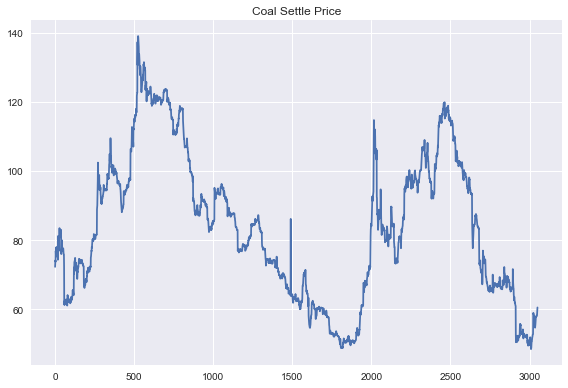

In [21]:
df['y'].plot(title='Coal Settle Price')
plt.tight_layout()
plt.show()

In [24]:
model_prophet = Prophet(seasonality_mode='multiplicative', daily_seasonality=True)
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(df)

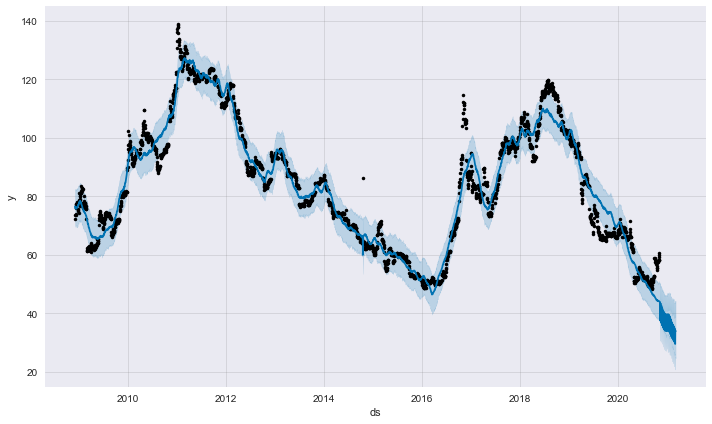

In [25]:
df_future = model_prophet.make_future_dataframe(periods=120)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

plt.tight_layout()
plt.show()

In [26]:
#This forecast can indeed be wrong! But who's to say :P

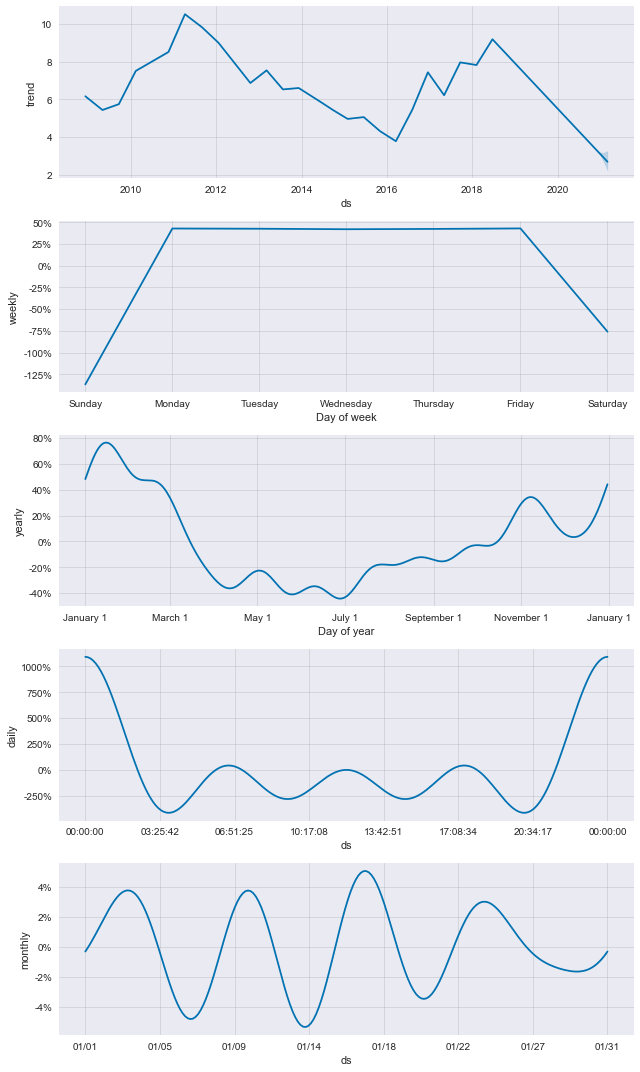

In [27]:
model_prophet.plot_components(df_pred)
plt.tight_layout()
plt.show()

In [28]:
#the peak of coal is in early of 2011, and 2018

In [29]:
df.describe()

,Open,High,Low,y,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
count,2386.000000,2386.000000,2386.000000,3051.000000,3018.000000,292.000000,404.000000,3048.000000,3.000000,287.000000,1023.000000
mean,82.715905,82.731660,82.698529,83.732327,-0.000056,76.334041,677.074257,2043.445866,962.333333,23.425087,54.385142
std,21.504939,21.506372,21.510779,21.012137,0.776777,21.153521,13353.920553,6334.022147,1658.149973,29.256410,290.852452
min,48.400000,48.500000,48.400000,48.500000,-6.650000,48.500000,1.000000,0.000000,5.000000,1.000000,1.000000
25%,65.300000,65.312500,65.262500,66.700000,-0.300000,58.000000,3.000000,1499.000000,5.000000,5.000000,10.000000
50%,80.750000,80.750000,80.750000,83.050000,0.000000,68.155000,6.000000,1930.000000,5.000000,15.000000,25.000000
75%,96.037500,96.050000,96.000000,98.025000,0.300000,97.000000,17.000000,2405.000000,1441.000000,30.000000,56.000000
max,139.050000,139.050000,139.050000,139.050000,7.200000,118.400000,268423.000000,349188.000000,2877.000000,220.000000,9173.000000


In [30]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)

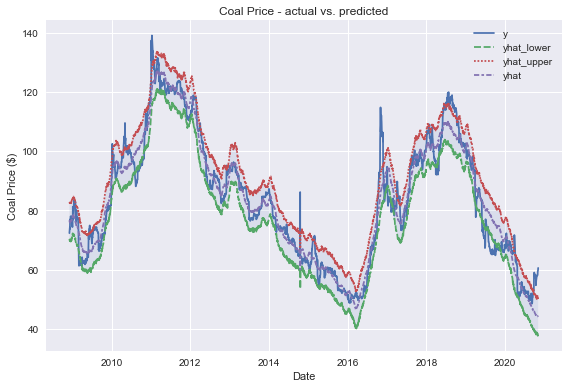

In [31]:
fig, ax = plt.subplots(1, 1)

ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 
                                'yhat_upper', 'yhat']])
ax.fill_between(df_test.index,
                df_test.yhat_lower,
                df_test.yhat_upper,
                alpha=0.1)
ax.set(title='Coal Price - actual vs. predicted',
       xlabel='Date',
       ylabel='Coal Price ($)')

plt.tight_layout()
plt.show()

In [32]:
#Bollinger, RSI and Fibonacci

Level Price
0 139
0.236 118
0.382 104
0.618 83
1 48


Text(0.5, 0, 'Date')

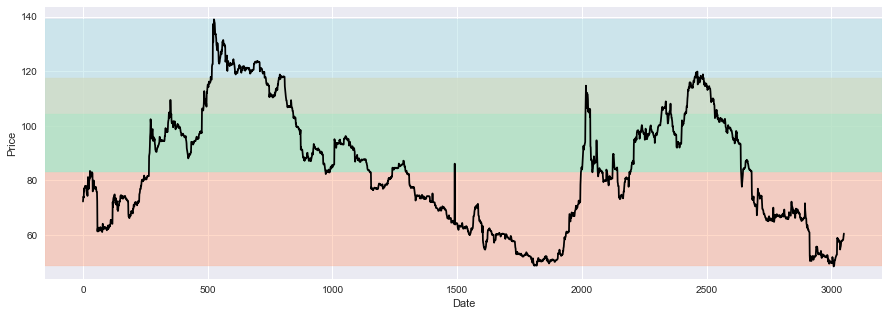

In [33]:
price_min = df.y.min()
price_max = df.y.max()

#fibonacci levels
diff = price_max - price_min
level1 = price_max - (0.236 * diff)
level2 = price_max - (0.382 * diff)
level3 = price_max - (0.618 * diff)

print("Level", "Price")
print("0", "%.0f" %price_max)
print("0.236", "%.0f" %level1)
print("0.382", "%.0f" %level2)
print("0.618", "%.0f" %level3)
print("1", "%.0f" %price_min)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df.y, color='black')

ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
ax.axhspan(price_max, level3, alpha=0.5, color='powderblue')

plt.ylabel("Price")
plt.xlabel("Date")

In [34]:
df['20_MA_Close'] = df['y'].rolling(window=20).mean()
df['20_std_Close'] = df['y'].rolling(window=20).std()

In [35]:
df['Upper'] = df['20_MA_Close'] + 2*df['20_std_Close']
df['Lower'] = df['20_MA_Close'] - 2*df['20_std_Close']

<AxesSubplot:>

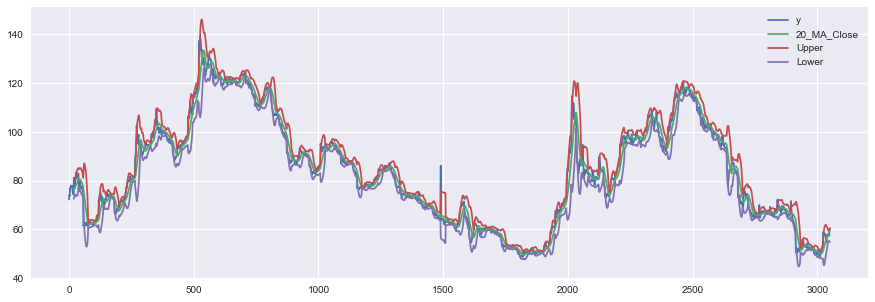

In [36]:
df[['y','20_MA_Close','Upper','Lower']].plot(figsize=(15,5))

In [37]:
df.tail()

,ds,Open,High,Low,y,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume,20_MA_Close,20_std_Close,Upper,Lower
3046,2020-10-28,NaN,NaN,NaN,58.20,0.05,NaN,NaN,2065.0,NaN,NaN,NaN,57.3950,1.062011,59.519023,55.270977
3047,2020-10-29,NaN,NaN,NaN,58.20,0.00,NaN,NaN,2065.0,NaN,NaN,NaN,57.3750,1.041696,59.458393,55.291607
3048,2020-10-30,59.50,59.50,59.50,59.25,0.35,59.50,1.0,2173.0,NaN,NaN,130.0,57.4600,1.122919,59.705838,55.214162
3049,2020-11-02,59.75,59.75,59.75,59.90,0.65,59.75,5.0,2288.0,NaN,NaN,NaN,57.5500,1.242663,60.035325,55.064675
3050,2020-11-03,60.00,60.60,60.00,60.55,0.65,60.45,14.0,2253.0,NaN,NaN,NaN,57.6725,1.409318,60.491136,54.853864


In [38]:
rsi_period= 14
change = df['y'].diff()
gain = change.mask(change < 0, 0)
loss = change.mask(change > 0, 0)
average_gain = gain.ewm(com= rsi_period-1, min_periods=rsi_period).mean()
average_loss = loss.ewm(com= rsi_period-1, min_periods=rsi_period).mean()
rs = abs(average_gain/average_loss)
rsi = 100 - (100/(1+rs))
df['rsi'] = rsi
print(df)

             ds   Open   High    Low      y  Change   Wave  Volume  \
0    2008-12-05  72.30  72.30  72.30  72.30     NaN    NaN     NaN   
1    2008-12-08  73.60  73.60  73.60  73.60    1.30    NaN     NaN   
2    2008-12-09  74.15  74.15  74.15  74.15    0.55    NaN     NaN   
3    2008-12-10  73.75  73.75  73.75  73.75   -0.40    NaN     NaN   
4    2008-12-11  76.90  76.90  76.90  76.90    3.15    NaN     NaN   
...         ...    ...    ...    ...    ...     ...    ...     ...   
3046 2020-10-28    NaN    NaN    NaN  58.20    0.05    NaN     NaN   
3047 2020-10-29    NaN    NaN    NaN  58.20    0.00    NaN     NaN   
3048 2020-10-30  59.50  59.50  59.50  59.25    0.35  59.50     1.0   
3049 2020-11-02  59.75  59.75  59.75  59.90    0.65  59.75     5.0   
3050 2020-11-03  60.00  60.60  60.00  60.55    0.65  60.45    14.0   

      Prev. Day Open Interest  EFP Volume  EFS Volume  Block Volume  \
0                         0.0         NaN         NaN           NaN   
1                

Shape of DataFrame: (3051, 17)


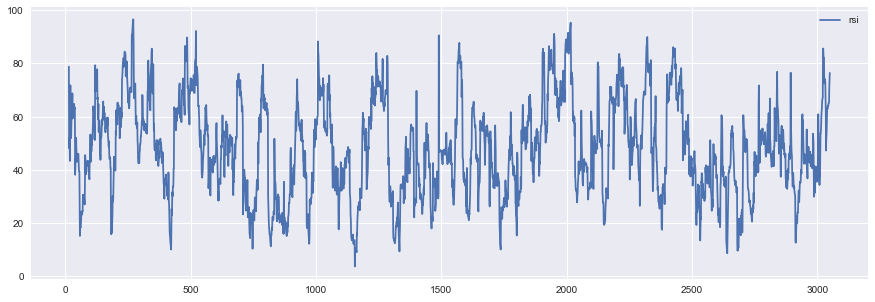

In [39]:
df[['rsi']].plot(figsize=(15,5))
print(f'Shape of DataFrame: {df.shape}')
#total data is 3050++ columns with 17 rows

In [40]:
#Predicting using Arima Class model

In [41]:
import pmdarima as pm

In [42]:
coal = df.y

In [45]:
auto_arima = pm.auto_arima(coal, 
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal=False,
                           stepwise=False,
                           approximation=False,
                           n_jobs=1)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3051
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -4971.815
Date:                Thu, 05 Nov 2020   AIC                           9953.629
Time:                        02:17:07   BIC                           9983.744
Sample:                             0   HQIC                          9964.452
                               - 3051                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.003     -0.113      0.910      -0.007       0.006
ar.L1          0.8032      0.060     13.458      0.000       0.686       0.920
ar.L2          0.0825      0.007     11.629      0.000       0.069       0.096
ma.L1         -0.8654      0.059    -14.616      0.000      -0.981      -0.749
sigma2         1.5255      0.007    203.714      0.000       1.511       1.540
===================================================================================
Ljung-Box (Q):                       28.98   Jarque-Bera (JB):            831999.85
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.45
Prob(H) (two-sided):                  0.01   Kurtosis:                        83.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
n_forecasts = len(coal)
arima = ARIMA(coal, order=(2, 1, 1)).fit(disp=0)
arima_pred = arima.forecast(n_forecasts)

arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']),
              pd.DataFrame(arima_pred[2], columns=['ci_lower', 
                                                   'ci_upper'])]
arima_pred = pd.concat(arima_pred, axis=1).set_index(coal.index)

In [47]:
plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

<Figure size 576x396 with 0 Axes>

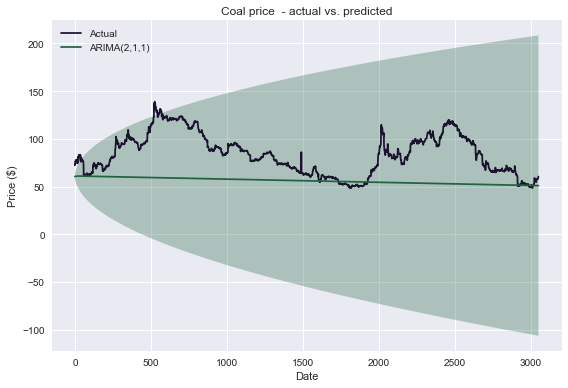

In [48]:
fig, ax = plt.subplots(1)

ax = sns.lineplot(data=coal, color=COLORS[0], label='Actual')

ax.plot(arima_pred.prediction, c=COLORS[1], label='ARIMA(2,1,1)')
ax.fill_between(arima_pred.index,
                arima_pred.ci_lower,
                arima_pred.ci_upper,
                alpha=0.3, 
                facecolor=COLORS[1])

ax.set(title="Coal price  - actual vs. predicted", 
       xlabel='Date', 
       ylabel='Price ($)')
ax.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/ch3_im25.png')
plt.show()

In [49]:
#tarik trendline bottom menggunakan arima